In [59]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
from pandas import DataFrame
import urllib.parse
import datetime as dt


In [6]:
def get_playercount(appid: int = 730) -> dict:
    """
    Extracts current playercount from Steam API and 24-hour and all-time peak from steamcharts.com

    Parameters:
        appid (int): Steam appid. Defaults to 730 (CS:GO)
    Returns:
        dict: A dictionary with the current playercount, 24-hour peak and all-time peak
    """
    page = requests.get(
        f'https://steamcharts.com/app/{appid}')
    soup = BeautifulSoup(page.content, 'lxml')
    tag = soup.find('div', id='app-heading')
    tags = tag.find_all('div', class_="app-stat")
    result = {}
    result['24-hour peak'] = int(tags[1].find('span').string)
    result['All-time peak'] = int(tags[2].find('span').string)
    response = requests.get(
        f'https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={appid}')
    result['Playercount'] = response.json().get(
        'response', {}).get('player_count', 0)
    return result


In [8]:
get_playercount()


{'24-hour peak': 1381271, 'All-time peak': 1519457, 'Playercount': 683179}

In [45]:
def get_unboxing_numbers() -> DataFrame:
    """
    Extracts unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with total, monthly, weekly and daily unboxing number for every case
    """
    daily_response = requests.get(
        'https://csgocasetracker.com/calculations/calcDaily.csv')
    daily_csv = StringIO(daily_response.content.decode('utf-8'))
    weekly_response = requests.get(
        'https://csgocasetracker.com/calculations/calcWeekly.csv')
    weekly_csv = StringIO(weekly_response.content.decode('utf-8'))
    monthly_response = requests.get(
        'https://csgocasetracker.com/calculations/calculation.csv')
    monthly_csv = StringIO(monthly_response.content.decode('utf-8'))
    total_response = requests.get(
        'https://csgocasetracker.com/calculations/calculationTotal.csv')
    total_csv = StringIO(total_response.content.decode('utf-8'))
    daily_df = pd.read_csv(daily_csv, sep=',')
    weekly_df = pd.read_csv(weekly_csv, sep=',')
    monthly_df = pd.read_csv(monthly_csv, sep=',')
    total_df = pd.read_csv(total_csv, sep=',')
    result = pd.DataFrame()
    result['Case Name'] = total_df['Case Name']
    result['Total Unboxing Number'] = total_df['Unboxing Number']
    result['Monthly Unboxing Number'] = monthly_df['Unboxing Number']
    result['Weekly Unboxing Number'] = weekly_df['Unboxing Number']
    result['Daily Unboxing Number'] = daily_df['Unboxing Number']
    return result


In [46]:
get_unboxing_numbers()


,Case Name,Total Unboxing Number,Monthly Unboxing Number,Weekly Unboxing Number,Daily Unboxing Number
0,CS:GO Weapon Case,4613846,25538,4923,923
1,eSports 2013 Case,3054000,11846,2000,0
2,Operation Bravo Case,3679866,14355,2392,0
3,CS:GO Weapon Case 2,4157122,26638,9401,0
4,eSports 2013 Winter Case,7622697,29249,4178,1044
5,Winter Offensive Weapon Case,14013029,55822,12579,2358
6,CS:GO Weapon Case 3,3997293,20370,7834,1566
7,Operation Phoenix Weapon Case,54477414,423360,75600,15120
8,Huntsman Weapon Case,23724482,49724,5849,0
9,Operation Breakout Weapon Case,59776979,385560,60480,7560


In [91]:
def get_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for an item from Steam

    Returns:
        DataFrame: A dataframe with price history containing datetimes, prices and amount sold for the given item
    """

    url = f"https://steamcommunity.com/market/listings/730/{urllib.parse.quote(item_name)}"
    response = requests.get(url).text
    response = response[response.find("line1")+6:]
    response = response[0:response.find("]];")+2]

    price_list = eval(response)
    month_list = [None,
                  'Jan',
                  'Feb',
                  'Mar',
                  'Apr',
                  'May',
                  'Jun',
                  'Jul',
                  'Aug',
                  'Sep',
                  'Oct',
                  'Nov',
                  'Dec']
    for i, entry in enumerate(price_list):
        # Date and time
        date_time = entry[0]
        date_time = date_time.split(" ")
        month = month_list.index(date_time[0])
        day = int(date_time[1])
        year = int(date_time[2])
        hour = int(date_time[3].split(":")[0])
        date_time = dt.datetime(
            year, month, day, hour=hour, minute=0, second=0)

        # Price
        price = float(entry[1])

        # Amount sold
        sold = int(entry[2])

        # compile dictionary and add it back to the list
        price_dict = {
            "Date": date_time,
            "Price(USD)": price,
            "Amount sold": sold
        }
        price_list[i] = price_dict

    df = pd.DataFrame.from_dict(price_list)

    return df


In [138]:
price_history = get_price_history('Dreams & Nightmares Case')
price_history


,Date,Price(USD),Amount sold
0,2022-01-21 01:00:00,10.675,76680
1,2022-01-22 01:00:00,6.173,70330
2,2022-01-23 01:00:00,4.914,62767
3,2022-01-24 01:00:00,4.328,52950
4,2022-01-25 01:00:00,3.996,51942
...,...,...,...
1146,2023-04-06 05:00:00,1.730,3889
1147,2023-04-06 06:00:00,1.750,5859
1148,2023-04-06 07:00:00,1.750,3811
1149,2023-04-06 08:00:00,1.702,2902


<AxesSubplot:xlabel='Date'>

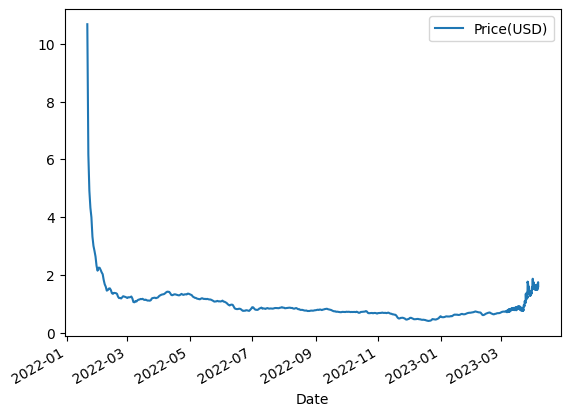

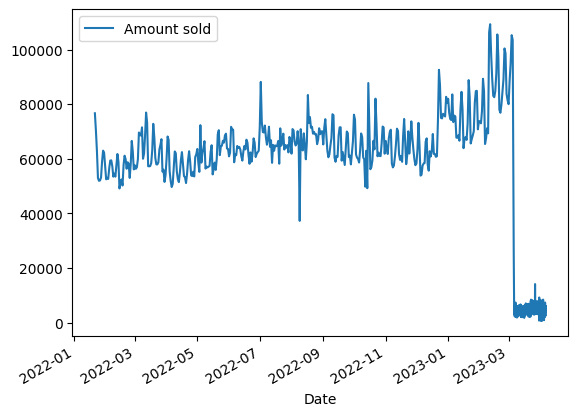

In [150]:
price_history.plot(x='Date', y='Price(USD)', rot=30)
price_history.plot(x='Date', y='Amount sold', rot=30)

In [133]:
def smoothen_price_history(df: DataFrame) -> DataFrame:
    """
    Aggregates hourly values for the past month into daily values so that time gaps between all values are consistent.

    Parameters:
        DataFrame: A dataframe with price history acquired from price_history
    Returns:
        DataFrame: A dataframe with price history with average daily prices and total daily amounts sold for the last month
    """
    df_copy = df.copy()
    df_copy['Date'] = df_copy['Date'].apply(lambda x: x.date())
    df_copy = df_copy.groupby('Date', as_index=False).agg(
        {'Price(USD)': 'mean', 'Amount sold': 'sum'})
    return df_copy


In [140]:
smooth_price_history = smoothen_price_history(price_history)
smooth_price_history


,Date,Price(USD),Amount sold
0,2022-01-21,10.675000,76680
1,2022-01-22,6.173000,70330
2,2022-01-23,4.914000,62767
3,2022-01-24,4.328000,52950
4,2022-01-25,3.996000,51942
...,...,...,...
436,2023-04-02,1.616125,119541
437,2023-04-03,1.560833,115700
438,2023-04-04,1.556542,102189
439,2023-04-05,1.599167,110576


<AxesSubplot:xlabel='Date'>

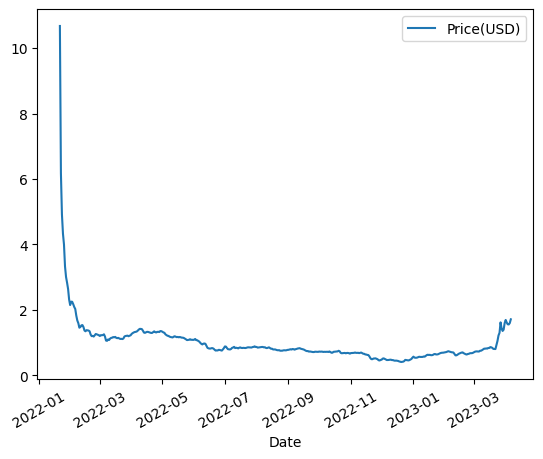

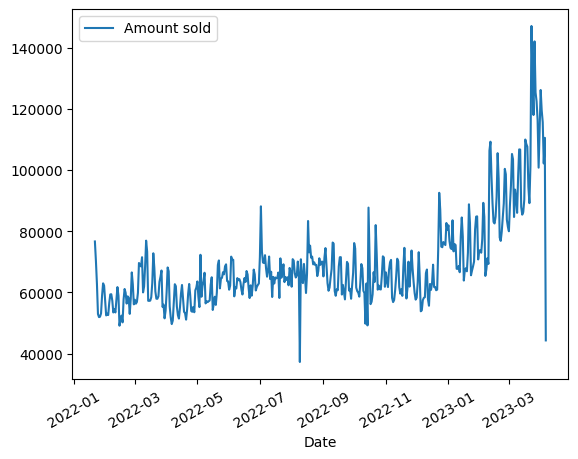

In [149]:
smooth_price_history.plot(x='Date', y='Price(USD)', rot=30)
smooth_price_history.plot(x='Date', y='Amount sold', rot=30)

In [137]:
def get_smooth_price_history(item_name: str)->DataFrame:
    """
    Extracts price history for an item from Steam with values from the last month aggregated to have daily instead of hourly data.

    Returns:
        DataFrame: A dataframe with price history containing dates, prices and amount sold for the given item
    """
    return smoothen_price_history(get_price_history(item_name))

In [142]:
smooth_price_history2 = get_smooth_price_history('Recoil Case')
smooth_price_history2

,Date,Price(USD),Amount sold
0,2022-07-01,18.725000,6647
1,2022-07-02,9.067000,65281
2,2022-07-03,6.088000,55152
3,2022-07-04,4.924000,50299
4,2022-07-05,4.465000,51490
...,...,...,...
275,2023-04-02,1.095208,108006
276,2023-04-03,1.048417,104154
277,2023-04-04,1.067417,90362
278,2023-04-05,1.124500,91551


<AxesSubplot:xlabel='Date'>

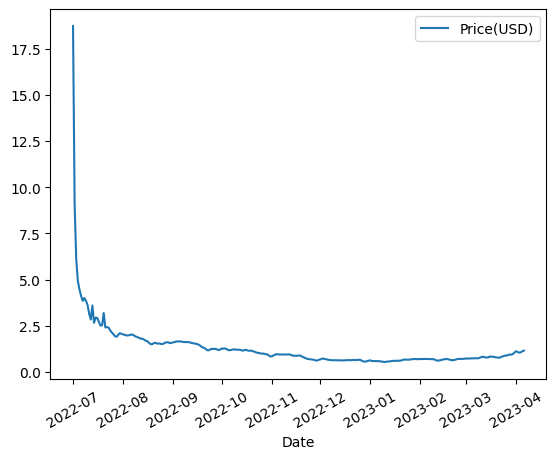

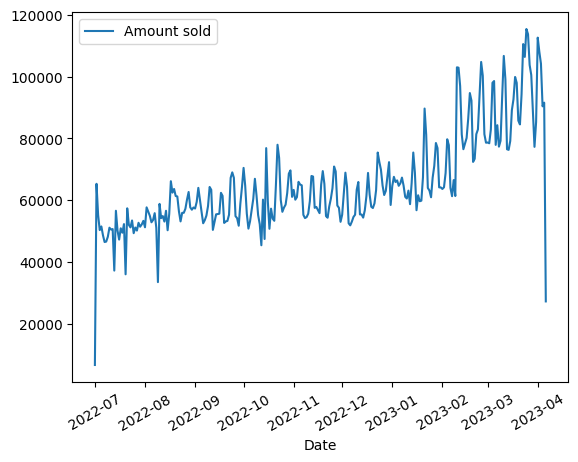

In [148]:
smooth_price_history2.plot(x='Date', y='Price(USD)', rot=30)

smooth_price_history2.plot(x='Date', y='Amount sold', rot=30)
